# 1. Data Cleaning: Listings.cvs
<hr/>

`Listings.cvs` contains detailed listings data, including various attributes (features) of each listing such as location, number of bedrooms, bathrooms, type of bed, reviews, etc for the month of January. The raw data contains 27,392 records and 52 columns. We will first load the data into a Pandas dataframe; however, not all of these columns are applicable for predicting listing prices. We will select the applicable predictors as follows:

### Column Selection

#### Selected Columns
- id
    - will not be used in the prediction, only used for indexing and referencing purposes
- host_id
    - will not be used in the prediction, only used for indexing and referencing purposes
- zipcode
- property_type
- room_type
- accommodates
- bathrooms
- bedrooms
- beds
- bed_type
- price
- minimum_nights
- availability_30
- number_of_reviews
- review_scores_rating
- host_listing_count
    
#### Removed Columns
- scrape_id
- last_scraped
- name (title used in the listing)
- picture_url
    - future studies may choose to integrate image analysis as a predictor
- host_name
    - there may certainly be some predictive power when considering gender / ethnicity of the name; however, we chose not to incorporate host_name for various ethical reasons as well as difficulty in discerning gender neutral names let alone ethnicity from a name
- host_since
    - better explained by number of reviews since a long time host may not actually have made any listings made over that period of time
- host_picture_url
- street
- neighbourhood
- neighbourhood_cleansed
- city
- state
    - these location features are better explained by zipcode, which will be easier to turn into a hot encoding as well. By using zipcode we can worry less and mitigate the effects of inaccurate location listings (captured by `is_location_exact` predictor) as a broader location category is used and for Airbnb the zipcode integrity is very often reliable by nature of the address input
- market
- country
- latitude
- longitude
    - location again better explained by zipcode
- is_location_exact
    - by using zipcode the exactness of location is mitigated (many records were indeed exact)
- square_feet
    - had 26,000+ (96% of original dataset) missing column values - too many to impute
- weekly_price
- monthly_price
    - `weekly` and `monthly` removed since we are focusing on single day listings
- guests_included
    - guests have their own price column that is calculated independently of the listing price
- extra_people
- maximum_nights
- calendar_updated
- calendar_last_scraped
- first_review
- last_review
- review_score_accuracy <-> review_scores_value

In [26]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import math
import pylab
import scipy.stats as stats
%matplotlib inline

In [27]:
cols = [
    'id',
    'host_id',
    'zipcode',
    'property_type',
    'room_type',
    'accommodates',
    'bedrooms',
    'beds',
    'bed_type',
    'price',
    'number_of_reviews',
    'review_scores_rating',
    'host_listing_count',
    'availability_30',
    'minimum_nights',
    'bathrooms'
]

data = pd.read_csv('../datasets/raw_datasets/listings.csv', usecols=cols)

In [28]:
data.head()

,id,host_id,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,minimum_nights,availability_30,number_of_reviews,review_scores_rating,host_listing_count
0,1069266,5867023,10022-4175,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,$160.00,3,21,62,86.0,1
1,1846722,2631556,NaN,Apartment,Entire home/apt,10,1.0,3.0,3.0,Real Bed,$105.00,1,28,22,85.0,2
2,2061725,4601412,11221,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,$58.00,3,4,35,98.0,4
3,44974,198425,10011,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,$185.00,10,1,26,96.0,1
4,4701675,22590025,10011,Apartment,Entire home/apt,2,1.0,1.0,2.0,Real Bed,$195.00,1,30,1,100.0,1


In [29]:
# determine the number of missing entries in each column
for col in data.columns:
    print col + ', Number of Missing Values:', len(data[col][data[col].isnull()])

id, Number of Missing Values: 0
host_id, Number of Missing Values: 0
zipcode, Number of Missing Values: 162
property_type, Number of Missing Values: 6
room_type, Number of Missing Values: 0
accommodates, Number of Missing Values: 0
bathrooms, Number of Missing Values: 463
bedrooms, Number of Missing Values: 140
beds, Number of Missing Values: 98
bed_type, Number of Missing Values: 0
price, Number of Missing Values: 0
minimum_nights, Number of Missing Values: 0
availability_30, Number of Missing Values: 0
number_of_reviews, Number of Missing Values: 0
review_scores_rating, Number of Missing Values: 8657
host_listing_count, Number of Missing Values: 0


### Data Cleaning

1. We drop any entries that are missing (NaN) values (except for review_scores_rating).
2. We convert the format in `price` from $1.00 into a float of 1.00. 
3. We also drop any entries that are inconsistent; i.e. predictors `accommodates`, `bedrooms`, `beds`, or `price` with a value of 0.
4. Convert ZipCode values such as 10022-4175 into 10022

In [30]:
# remove NaN values from dataframe
original = len(data)
data = data.dropna(how='any', subset=['zipcode', 'property_type', 'bedrooms', 'beds', 'bathrooms'])
print 'Number of NaN values removed:', original - len(data)

# convert formatting for price
data['price'] = (data['price'].str.replace(r'[^-+\d.]', '').astype(float))

# drop any inconsistent values
print 'Number of Accommodates 0:', len(data[data['accommodates'] == 0])
print 'Number of Bedrooms 0:', len(data[data['bedrooms'] == 0])
print 'Number of Beds 0:', len(data[data['beds'] == 0])
print 'Number of Listings with Price $0.00:', len(data[data['price'] == 0.00])

data = data[data['accommodates'] != 0]
data = data[data['bedrooms'] != 0]
data = data[data['beds'] != 0]
data = data[data['price'] != 0.00]

# convert ZipCode
data['zipcode'] = data['zipcode'].str.replace(r'-\d+', '')

Number of NaN values removed: 769
Number of Accommodates 0: 0
Number of Bedrooms 0: 2321
Number of Beds 0: 0
Number of Listings with Price $0.00: 0


In [31]:
# we see the data is now clean
data.head()

,id,host_id,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,minimum_nights,availability_30,number_of_reviews,review_scores_rating,host_listing_count
0,1069266,5867023,10022,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,160.0,3,21,62,86.0,1
2,2061725,4601412,11221,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,58.0,3,4,35,98.0,4
3,44974,198425,10011,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,185.0,10,1,26,96.0,1
4,4701675,22590025,10011,Apartment,Entire home/apt,2,1.0,1.0,2.0,Real Bed,195.0,1,30,1,100.0,1
5,68914,343302,11231,Apartment,Entire home/apt,6,1.0,2.0,3.0,Real Bed,165.0,2,11,16,96.0,2


In [32]:
print 'Number of missing review scores ratings:', len(data['review_scores_rating'][data['review_scores_rating'].isnull()])

Number of missing review scores ratings: 7712


In [33]:
# explore distribution of accommodates
print 'Number of Unique Accomodation: ', np.unique(data['accommodates'])
for i in range(1, 17):
    print 'Accommodation {}:'.format(i), len(data[data['accommodates'] == i])

Number of Unique Accomodation:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Accommodation 1: 2643
Accommodation 2: 11400
Accommodation 3: 2909
Accommodation 4: 4278
Accommodation 5: 982
Accommodation 6: 1214
Accommodation 7: 217
Accommodation 8: 333
Accommodation 9: 57
Accommodation 10: 119
Accommodation 11: 15
Accommodation 12: 43
Accommodation 13: 4
Accommodation 14: 14
Accommodation 15: 5
Accommodation 16: 69


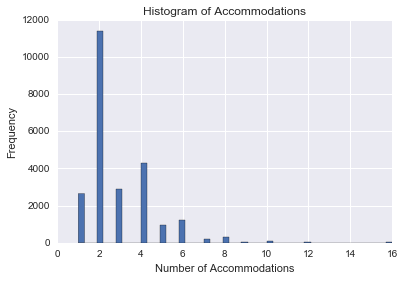

In [34]:
# visualize distribution of price (target variable)
plt.hist(data['accommodates'], bins=50)
plt.title("Histogram of Accommodations")
plt.xlabel("Number of Accommodations")
plt.ylabel("Frequency")
plt.show()

We see that a majority of listings have accomodations for 1-4 people. 1 bed typically accomodates 2 individuals, so let's plot beds instead to analyze how many of the listings are single bedroom listings.

In [35]:
print 'Number of Unique Beds: ', np.unique(data['beds'])
for i in range(1, 17):
    print 'Beds {}:'.format(i), len(data[data['beds'] == i])

Number of Unique Beds:  [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  16.]
Beds 1: 16002
Beds 2: 5418
Beds 3: 1770
Beds 4: 610
Beds 5: 243
Beds 6: 117
Beds 7: 41
Beds 8: 22
Beds 9: 3
Beds 10: 20
Beds 11: 4
Beds 12: 9
Beds 13: 1
Beds 14: 15
Beds 15: 0
Beds 16: 27


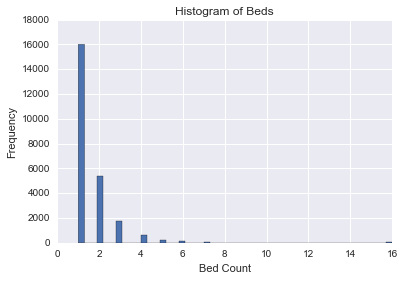

In [36]:
# visualize distribution of beds
plt.hist(data['beds'], bins=50)
plt.title("Histogram of Beds")
plt.xlabel("Bed Count")
plt.ylabel("Frequency")
plt.show()

We see that a majority of our listings are indeed single bedroom listings roughly 66%.

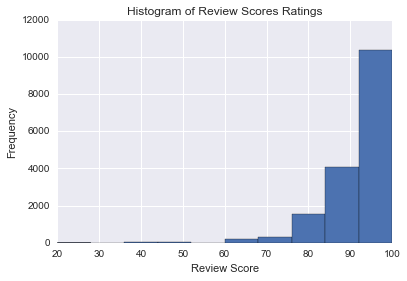

In [37]:
# visualize distribution of review scores ratings
plt.hist(data['review_scores_rating'][~data['review_scores_rating'].isnull()])
plt.title("Histogram of Review Scores Ratings")
plt.xlabel("Review Score")
plt.ylabel("Frequency")
plt.show()

There are 7712 listings with no review_scores_rating (NaN) values. We will handle this by turning the `review_scores_ratings` into a categorical predictor. Based on the histogram, we see that a vast majority of the listings seem to have overall favorable ratings; i.e. skewed left distribution. We replace any NaN values that have no review with 'No Reviews' and we remove any remaining inconsistent NaN values that have a `number_of_reviews` > 0. We will also convert the `review_scores_ratings` into buckets. We will have the bucket ranges set more closely to a higher review score to accomodate for the skewed left distribution of the review scores.

In [44]:
print len(data)
print len(data[data['zipcode'].map(len) == 5])

24053
24050


In [38]:
# turn NaN scores with 0 reviews into 'No Reviews'
idx_vals = data['review_scores_rating'][data['number_of_reviews'] == 0].index.values.tolist()
data.loc[idx_vals, ('review_scores_rating')] = data['review_scores_rating'][data['number_of_reviews'] == 0].replace('NaN', 'No Reviews')

# remove inconsistent NaN values
data = data[~data['review_scores_rating'].isnull()]

data = data[data['zipcode'] == 5]

KeyError: False

In [14]:
# convert review_scores_rating into buckets
def convert_scores_buckets(val):
    if val == 'No Reviews':
        return 'No Reviews'
    elif val >= 95.0:
        return '95-100'
    elif val >= 90.0 and val < 95.0:
        return '90-94'
    elif val >= 85.0 and val < 90.0:
        return '85-89'
    elif val >= 80.0 and val < 85.0:
        return '80-84'
    elif val >= 70.0 and val < 80.0:
        return '70-79'
    elif val >= 60.0 and val < 70.0:
        return '60-69'
    elif val >= 50.0 and val < 60.0:
        return '50-59'
    elif val >= 40.0 and val < 50.0:
        return '40-49'
    elif val >= 30.0 and val < 40.0:
        return '30-39'
    elif val >= 20.0 and val < 30.0:
        return '20-29'
    elif val >= 10.0 and val < 20.0:
        return '10-19'
    elif val < 10.0:
        return '0-9'
    
data['review_scores_rating'] = data['review_scores_rating'].apply(convert_scores_buckets)
print 'Unique Values in the Column:', np.unique(data['review_scores_rating'])

Unique Values in the Column: ['20-29' '30-39' '40-49' '50-59' '60-69' '70-79' '80-84' '85-89' '90-94'
 '95-100' 'No Reviews']


In [15]:
print 'Number of remaining records:', len(data)

Number of remaining records: 24053


Our dataset is now clean and we no longer have any missing values. We have a total of 24,053 records from the original 27,392; thus, we've retained a reasonable amount of records. We have a few columns that contain categorical predictors. The regressors in scikit learn require numeric fields; thus we will use the `get_dummies` routine in Pandas to convert these into 'dummy' variables (one hot encoding); i.e we will add a column for every possible value of the field. We will standardize the non-categorical predictors and convert them to floating point values since we will later try linear regression models such as Ridge and Lasso regression.

In [16]:
# encode categorical variables
zipcode_dummies = pd.get_dummies(data['zipcode'])
property_dummies = pd.get_dummies(data['property_type'])
room_dummies = pd.get_dummies(data['room_type'])
bed_dummies = pd.get_dummies(data['bed_type'])
ratings_scores_dummies = pd.get_dummies(data['review_scores_rating'])

# replace the old columns with our new one-hot encoded ones
df = pd.concat((data.drop(['zipcode', \
    'property_type', 'room_type', 'bed_type', 'review_scores_rating'], axis=1), \
    zipcode_dummies.astype(int), property_dummies.astype(int), \
    room_dummies.astype(int), bed_dummies.astype(int), ratings_scores_dummies.astype(int)), \
    axis=1)

print 'Number of Columns:', len(df.columns)

# move target predictor 'price' to the end of the dataframe
cols = list(df.columns.values)
idx = cols.index('price')
rearrange_cols = cols[:idx] + cols[idx+1:] + [cols[idx]]
df = df[rearrange_cols]

Number of Columns: 232


In [17]:
# convert non-categorical variables to floats and standardize
def standardize_col(col):
    mean = np.mean(col)
    std = np.std(col)
    return col.apply(lambda x: (x - mean) / std)

non_cat_vars = ['accommodates', 'bedrooms', 'beds', 'number_of_reviews', 'host_listing_count', 'availability_30', 'availability_60', 'minimum_nights', 'availability_90', 'availability_365', 'bathrooms']
for col in non_cat_vars:
    df[col] = df[col].astype(float)
    df[col] = standardize_col(df[col])
    
df.head()

,id,host_id,accommodates,bathrooms,bedrooms,beds,minimum_nights,availability_30,availability_60,availability_90,...,40-49,50-59,60-69,70-79,80-84,85-89,90-94,95-100,No Reviews,price
0,1069266,5867023,-0.520256,-0.331519,-0.407440,-0.493059,0.173446,0.390321,0.679252,0.502078,...,0,0,0,0,0,1,0,0,0,160.0
2,2061725,4601412,-0.520256,-0.331519,-0.407440,0.381668,0.173446,-0.965980,-0.886682,-0.771500,...,0,0,0,0,0,0,0,1,0,58.0
3,44974,198425,-0.520256,-0.331519,-0.407440,-0.493059,2.885991,-1.205327,-1.381187,-1.463662,...,0,0,0,0,0,0,0,1,0,185.0
4,4701675,22590025,-0.520256,-0.331519,-0.407440,0.381668,-0.601567,1.108363,1.050131,1.000435,...,0,0,0,0,0,0,0,1,0,195.0
5,68914,343302,1.690843,-0.331519,1.266082,1.256396,-0.214061,-0.407503,-0.062506,0.086781,...,0,0,0,0,0,0,0,1,0,165.0


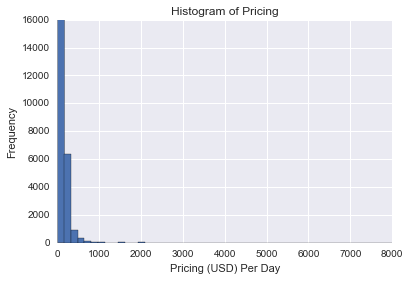

In [18]:
# visualize distribution of price (target variable)
plt.hist(df['price'], bins=50)
plt.title("Histogram of Pricing")
plt.xlabel("Pricing (USD) Per Day")
plt.ylabel("Frequency")
plt.show()

We see the distribution for pricing is strongly skewed right. This again makes sense as a majority of the listings on Airbnb are single individual listings. Additionally, the market population for Airbnb does strongly cater to travelers who are looking for cheaper places to stay for short durations of time. There are of course listings with a high pricing as well; intuitively this matches with hosts that are listing a high value property such as an entire house. To compensate for the skewed right distribution, we will log the response variable and store the results in a new panda column. We will then run our baseline models on both the logged and original response and compare the results.

In [19]:
# log transform the response 'price'
df['price_log'] = df['price'].apply(lambda x: math.log(x))

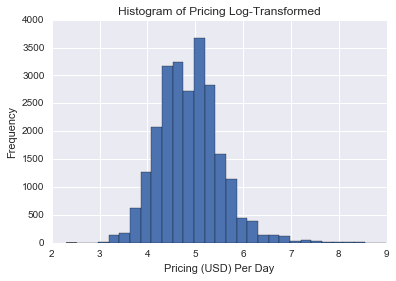

In [20]:
# visualize distribution of price (target variable)
plt.hist(df['price_log'], bins=30)
plt.title("Histogram of Pricing Log-Transformed")
plt.xlabel("Pricing (USD) Per Day")
plt.ylabel("Frequency")
plt.show()

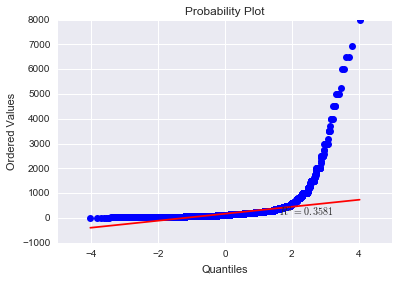

In [21]:
# qq plot for log-transformed pricing
stats.probplot(df['price'], dist="norm", plot=pylab)
pylab.show()

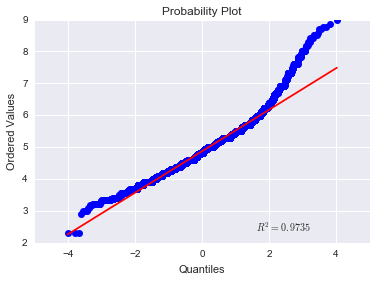

In [22]:
# qq plot for log-transformed pricing
stats.probplot(df['price_log'], dist="norm", plot=pylab)
pylab.show()

We see that after transformation, the distribution for `price` resembles that of a normal distribution. We see from the Q-Q plots that log-transforming the response variable yields a distribution that more closely resembles that of a normal distribution. This assumption is important in order to fit the assumptions of linear regression models.

In [47]:
# read to csv
df.to_csv('../datasets/listings_clean.csv', index=False)

In [25]:
data['zipcode'].unique()

array(['10022', '11221', '10011', '11231', '11207', '10013', '10003',
       '10018', '11213', '10019', '10014', '10040', '10033', '11238',
       '10038', '10027', '11222', '11206', '10025', '10030', '10035',
       '10009', '10031', '10026', '10012', '11102', '10128', '11101',
       '11385', '10028', '11211', '11215', '10007', '11205', '10002',
       '11217', '10010', '11237', '10024', '10016', '10039', '11233',
       '10037', '10455', '11220', '11249', '11216', '10075', '11235',
       '11201', '11374', '10036', '11234', '10001', '10032', '11103',
       '10463', '11106', '11230', '10466', '11372', '11377', '11109',
       '11105', '10301', '10017', '11210', '10065', '11226', '10021',
       '11373', '10004', '11432', '11415', '10306', '10023', '10034',
       '11413', '10005', '11236', '10029', '11225', '11365', '11355',
       '11204', '11375', '11369', '11208', '11370', '11361', '10464',
       '11378', '11223', '11104', '11203', '10451', '11358', '11421',
       '11433', '104